<a href="https://colab.research.google.com/github/Lavyadev/Vision-Transformer-Based-Classification/blob/main/Vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision numpy matplotlib scikit-learn tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torchvision.models import vit_b_16

# 📌 Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [4]:
!wget -O Dataset1.npy "https://cernbox.cern.ch/remote.php/dav/public-files/cDOFb5myDHGqRfc/Run355456_Dataset_jqkne.npy"
!wget -O Dataset2.npy "https://cernbox.cern.ch/remote.php/dav/public-files/n8NvyK2ldUPUxa9/Run357479_Dataset_iodic.npy"

# 📌 Load the datasets
data1 = np.load("Dataset1.npy")  # Shape: (10000, 64, 72)
data2 = np.load("Dataset2.npy")  # Shape: (10000, 64, 72)

print("Dataset 1 shape:", data1.shape)
print("Dataset 2 shape:", data2.shape)


--2025-03-15 17:12:15--  https://cernbox.cern.ch/remote.php/dav/public-files/cDOFb5myDHGqRfc/Run355456_Dataset_jqkne.npy
Resolving cernbox.cern.ch (cernbox.cern.ch)... 137.138.120.151, 128.142.53.28, 128.142.53.35, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|137.138.120.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368640128 (352M) [application/octet-stream]
Saving to: ‘Dataset1.npy’

Dataset1.npy        100%[===================>] 351.56M  22.0MB/s    in 18s     

2025-03-15 17:12:35 (19.8 MB/s) - ‘Dataset1.npy’ saved [368640128/368640128]

--2025-03-15 17:12:35--  https://cernbox.cern.ch/remote.php/dav/public-files/n8NvyK2ldUPUxa9/Run357479_Dataset_iodic.npy
Resolving cernbox.cern.ch (cernbox.cern.ch)... 137.138.120.151, 128.142.53.28, 128.142.53.35, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|137.138.120.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368640128 (352M) [application/octet-stream]
Saving to: ‘

In [5]:
# Labels (0 for data1, 1 for data2)
labels1 = np.zeros((data1.shape[0],))
labels2 = np.ones((data2.shape[0],))

# Stack data and labels together
X = np.vstack((data1, data2))
y = np.hstack((labels1, labels2))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Compute dataset mean & std
mean = X_train.mean() / 255.0
std = X_train.std() / 255.0


In [7]:
from torchvision.transforms import AutoAugment, AutoAugmentPolicy

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    AutoAugment(AutoAugmentPolicy.IMAGENET),  # Stronger augmentation ✅
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),  # ✅ Convert to float AFTER augmentations
    transforms.Normalize((mean,), (std,))
])


In [8]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]  # Shape: (64, 72)
        img = np.expand_dims(img, axis=-1)  # Add channel (64, 72, 1)
        img = np.repeat(img, 3, axis=-1)    # Convert grayscale to 3-channel (64, 72, 3)

        img = (img * 255).astype(np.uint8)  # ✅ Convert to uint8 for PIL
        img = transforms.ToPILImage()(img)

        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]
        return img, torch.tensor(label, dtype=torch.long)


In [9]:
train_dataset = CustomDataset(X_train, y_train, transform=transform)
test_dataset = CustomDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Print sample batch
sample_batch, sample_labels = next(iter(train_loader))
print("Batch Shape:", sample_batch.shape, "Labels Shape:", sample_labels.shape)


Batch Shape: torch.Size([64, 3, 224, 224]) Labels Shape: torch.Size([64])


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Pretrained ViT Model
model = vit_b_16(weights="IMAGENET1K_V1")

# Modify classification head for binary classification
model.heads.head = nn.Linear(768, 2)

model = model.to(device)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 158MB/s]


In [11]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)


In [12]:
import torch
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=20):
    model.to(device)
    model.train()

    scaler = GradScaler()
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():  # ✅ Mixed precision
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total

        # 🔹 Validate Model
        val_acc = validate_model(model, test_loader)

        # 🔹 Adjust Learning Rate
        scheduler.step(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Acc: {val_acc:.4f}")

    print("🎉 Training Complete!")


def validate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    model.train()
    return correct / total


In [13]:
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=30)


<ipython-input-12-dbb2713a2122>:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
  0%|          | 0/250 [00:00<?, ?it/s]<ipython-input-12-dbb2713a2122>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ Mixed precision
100%|██████████| 250/250 [03:32<00:00,  1.17it/s]


Epoch [1/30], Loss: 0.6952, Train Acc: 0.5160, Val Acc: 0.5010


100%|██████████| 250/250 [03:24<00:00,  1.22it/s]


Epoch [2/30], Loss: 0.6734, Train Acc: 0.5583, Val Acc: 0.5000


100%|██████████| 250/250 [03:25<00:00,  1.22it/s]


Epoch [3/30], Loss: 0.6510, Train Acc: 0.6021, Val Acc: 0.6428


100%|██████████| 250/250 [03:25<00:00,  1.22it/s]


Epoch [4/30], Loss: 0.6294, Train Acc: 0.6424, Val Acc: 0.6430


100%|██████████| 250/250 [03:25<00:00,  1.22it/s]


Epoch [5/30], Loss: 0.6184, Train Acc: 0.6589, Val Acc: 0.5982


100%|██████████| 250/250 [03:25<00:00,  1.22it/s]


Epoch [6/30], Loss: 0.6091, Train Acc: 0.6686, Val Acc: 0.6723


100%|██████████| 250/250 [03:24<00:00,  1.22it/s]


Epoch [7/30], Loss: 0.6048, Train Acc: 0.6801, Val Acc: 0.6895


100%|██████████| 250/250 [03:24<00:00,  1.22it/s]


Epoch [8/30], Loss: 0.6021, Train Acc: 0.6836, Val Acc: 0.6910


100%|██████████| 250/250 [03:24<00:00,  1.22it/s]


Epoch [9/30], Loss: 0.5940, Train Acc: 0.6909, Val Acc: 0.6830


100%|██████████| 250/250 [03:25<00:00,  1.22it/s]


Epoch [10/30], Loss: 0.5897, Train Acc: 0.7010, Val Acc: 0.6757


100%|██████████| 250/250 [03:25<00:00,  1.22it/s]


Epoch [11/30], Loss: 0.5948, Train Acc: 0.6894, Val Acc: 0.6920


100%|██████████| 250/250 [03:24<00:00,  1.22it/s]


Epoch [12/30], Loss: 0.5887, Train Acc: 0.7005, Val Acc: 0.6957


100%|██████████| 250/250 [03:24<00:00,  1.22it/s]


Epoch [13/30], Loss: 0.5805, Train Acc: 0.7093, Val Acc: 0.6775


100%|██████████| 250/250 [03:24<00:00,  1.22it/s]


Epoch [14/30], Loss: 0.5782, Train Acc: 0.7061, Val Acc: 0.6953


100%|██████████| 250/250 [03:25<00:00,  1.22it/s]


Epoch [15/30], Loss: 0.5758, Train Acc: 0.7139, Val Acc: 0.7113


100%|██████████| 250/250 [03:25<00:00,  1.22it/s]


Epoch [16/30], Loss: 0.5738, Train Acc: 0.7182, Val Acc: 0.7133


100%|██████████| 250/250 [03:25<00:00,  1.22it/s]


Epoch [17/30], Loss: 0.5733, Train Acc: 0.7171, Val Acc: 0.7047


100%|██████████| 250/250 [03:25<00:00,  1.22it/s]


Epoch [18/30], Loss: 0.5717, Train Acc: 0.7197, Val Acc: 0.7017


100%|██████████| 250/250 [03:24<00:00,  1.22it/s]


Epoch [19/30], Loss: 0.5744, Train Acc: 0.7167, Val Acc: 0.7110


100%|██████████| 250/250 [03:25<00:00,  1.22it/s]


Epoch [20/30], Loss: 0.5672, Train Acc: 0.7241, Val Acc: 0.7195


100%|██████████| 250/250 [03:24<00:00,  1.22it/s]


Epoch [21/30], Loss: 0.5709, Train Acc: 0.7186, Val Acc: 0.7205


100%|██████████| 250/250 [03:25<00:00,  1.22it/s]


Epoch [22/30], Loss: 0.5626, Train Acc: 0.7289, Val Acc: 0.7183


100%|██████████| 250/250 [03:25<00:00,  1.22it/s]


Epoch [23/30], Loss: 0.5646, Train Acc: 0.7216, Val Acc: 0.7060


100%|██████████| 250/250 [03:24<00:00,  1.22it/s]


Epoch [24/30], Loss: 0.5636, Train Acc: 0.7269, Val Acc: 0.7202


100%|██████████| 250/250 [03:24<00:00,  1.22it/s]


Epoch [25/30], Loss: 0.5652, Train Acc: 0.7238, Val Acc: 0.6857


100%|██████████| 250/250 [03:25<00:00,  1.22it/s]


Epoch [26/30], Loss: 0.5508, Train Acc: 0.7388, Val Acc: 0.7245


100%|██████████| 250/250 [03:24<00:00,  1.22it/s]


Epoch [27/30], Loss: 0.5453, Train Acc: 0.7455, Val Acc: 0.7390


100%|██████████| 250/250 [03:25<00:00,  1.22it/s]


Epoch [28/30], Loss: 0.5392, Train Acc: 0.7555, Val Acc: 0.7275


100%|██████████| 250/250 [03:24<00:00,  1.22it/s]


Epoch [29/30], Loss: 0.5421, Train Acc: 0.7458, Val Acc: 0.7395


100%|██████████| 250/250 [03:24<00:00,  1.22it/s]


Epoch [30/30], Loss: 0.5374, Train Acc: 0.7532, Val Acc: 0.7412
🎉 Training Complete!


✅ Model Accuracy: 0.7380
✅ Model AUC: 0.8112


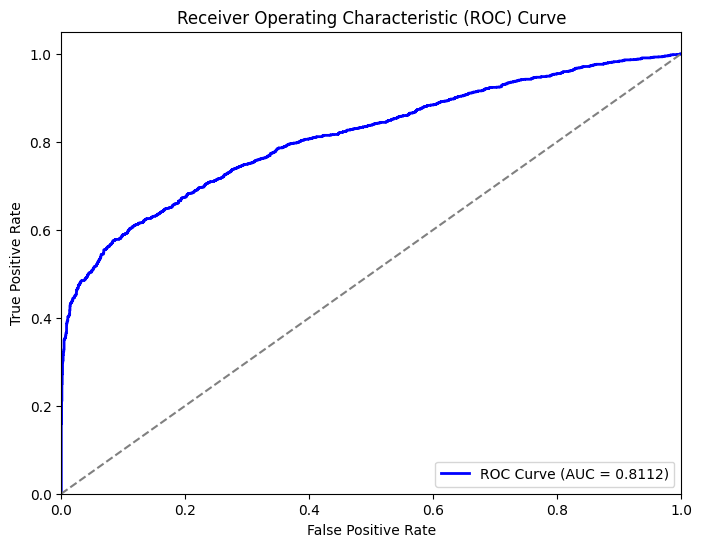

(0.738, 0.8111905)

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_probs = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]  # Probability for class 1
            preds = torch.argmax(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Compute Accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'✅ Model Accuracy: {accuracy:.4f}')

    # Compute ROC Curve and AUC
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    print(f'✅ Model AUC: {roc_auc:.4f}')

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    return accuracy, roc_auc

# Run evaluation
evaluate_model(model, test_loader)
